Drawing the corner from numpy file. The benefit is that variable name is in file. Burnin is already applied.

In [18]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
result = np.load('./np_m.npy')
array_2d = result.view((np.float64, len(result.dtype.names)))

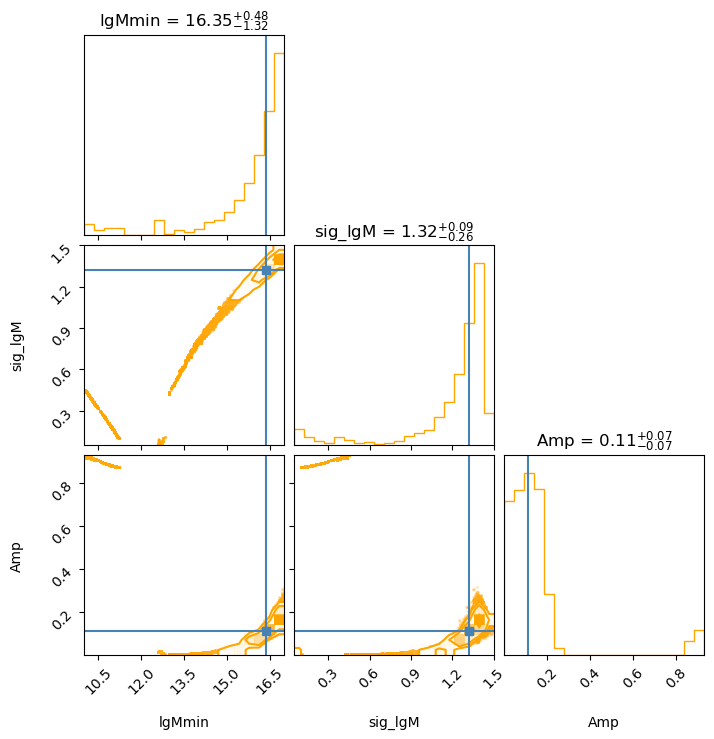

In [24]:
fig = corner.corner(array_2d, labels=result.dtype.names, show_titles=True, color='orange', truths=np.percentile(array_2d, 50, axis=0))
# This will not work for 1-d mcmc; just use sns.histplot to plot it.

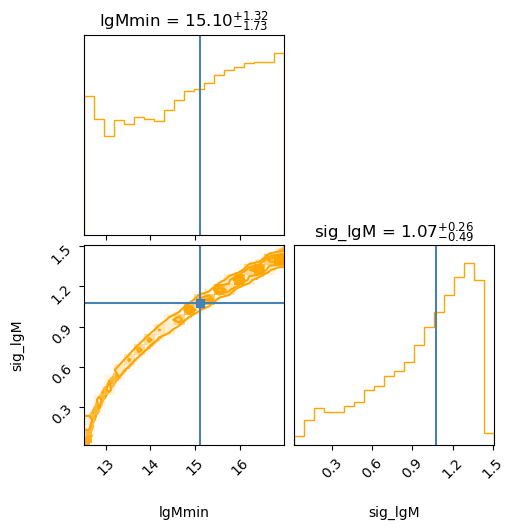

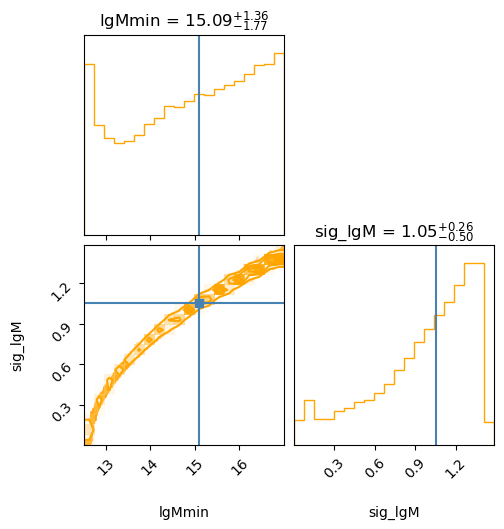

In [5]:
result = np.load('./np_2.npy')
array_2d = result.view((np.float64, len(result.dtype.names)))
fig1 = corner.corner(array_2d, labels=result.dtype.names, show_titles=True, color='orange', truths=np.percentile(array_2d, 50, axis=0))

result = np.load('./np_auto.npy')
array_2d = result.view((np.float64, len(result.dtype.names)))
fig2 = corner.corner(array_2d, labels=result.dtype.names, show_titles=True, color='orange', truths=np.percentile(array_2d, 50, axis=0))
# This will not work for 1-d mcmc; just use sns.histplot to plot it.

In [2]:
from read_files import *
from calc_wp import w_p
from run_mcmc import HODParameter

In [3]:
with open('config.yaml', 'r') as f:
    par_configs, other_configs = list(yaml.load_all(f, yaml.FullLoader))
# ========== reading configs ==========

# don't set the lgMmin too large or sig_lgM too small, otherwise N_c will be all zeros
available_fields = ['Nwalkers', 'Nstep', 'Nburnin', 'Npro', 'auto_range', 'cross_range',
                    'backend_file', 'numpy_file', 'wp_table_path', 'signal_path']
Nwalkers = 40
Nstep = 4000
Nburnin = 300
Npro = 40
auto_range = None
cross_range = None
backend_file = ''
numpy_file = ''
wp_table_path = '../wp_table'
signal_path = '../signal'

for k in available_fields:
    if k in other_configs:
        locals()[k] = other_configs[k]

wp_table = read_wp(wp_table_path)
rp_auto, signal_auto, rp_cross, signal_cross, number_density = read_signal(signal_path + '/signal.npy')
cov = read_cov(signal_path + '/cov.npy')
logM, Nh = read_halo_mass_function('../halo_mass_function.npy')
# for better performance I would recommend setting these as global variable

# ========== apply the fitting range ==========

if auto_range or cross_range:
    if auto_range is None:
        auto_range = [0, len(rp_auto)]
    if cross_range is None:
        cross_range = [0, len(rp_cross)]
    l_a, r_a = auto_range[0], auto_range[1]
    l_c, r_c = cross_range[0], cross_range[1]

    auto_size = len(rp_auto)
    cross_size = len(rp_cross)
    rp_auto = rp_auto[l_a:r_a]
    rp_cross = rp_cross[l_c:r_c]
    signal_auto = signal_auto[l_a:r_a]
    signal_cross = signal_cross[l_c:r_c]

    cov = np.vstack((
        np.hstack((cov[l_c:r_c, l_c:r_c], cov[l_c:r_c, cross_size+l_a:cross_size+r_a], cov[l_c:r_c, -1].reshape(-1, 1))),
        np.hstack((cov[cross_size+l_a:cross_size+r_a, l_c:r_c], cov[cross_size+l_a:cross_size+r_a, cross_size+l_a:cross_size+r_a], cov[cross_size+l_a:cross_size+r_a, -1].reshape(-1, 1))),
        np.hstack((cov[-1, l_c:r_c], cov[-1, cross_size+l_a:cross_size+r_a], [cov[-1, -1]]))
    ))

signal = np.concatenate((signal_cross, signal_auto, [number_density]))
cov_inv = np.linalg.inv(cov)

# ========== handle interpolating table ==========
wp_table_auto = interpolate_table(wp_table, rp_auto)
wp_table_cross = interpolate_table(wp_table, rp_cross)

parameter = HODParameter.from_config(par_configs)
print(parameter)

HODParameter(lgMmin:    12  [10~16]
             sig_lgM:   1   [0.001~3]
             Amp:       0.3 [fixed]
             lgM0:      50  [fixed]
             lgM1p:     12  [fixed]
             alpha:     1   [fixed])


In [9]:
np.sqrt([cov[i, i] for i in range(len(rp_cross), len(rp_cross)+len(rp_auto))])

array([6.27909617, 5.95107544, 4.27517457, 3.00999183, 2.70611563,
       2.07926116, 1.66454057, 1.33162498, 1.01383611, 0.82699209,
       0.60951535, 0.54475606, 0.42140508, 0.37768577, 0.27951185,
       0.24024691, 0.1997338 ])

In [8]:
signal_auto

array([75.95267449, 53.65866909, 42.48711639, 38.10253441, 34.44609476,
       29.71671764, 23.34265463, 18.95604146, 18.25013698, 12.60655404,
       10.24886465,  8.22416787,  6.0585224 ,  3.97887872,  3.48310319,
        2.31237548,  1.30723376])

In [7]:
number_density

array(4.43768502e-06)

In [6]:
np.sqrt(cov[-1, -1])

3.027751535128321e-08

In [43]:
predict = w_p(logM, Nh, parameter.full_parameters(np.percentile(array_2d, 50, axis=0)), wp_table_auto, wp_table_cross)

In [44]:
pre_cross = predict[:len(rp_cross)]
pre_auto = predict[len(rp_cross):]

In [37]:
std = np.sqrt([cov[i, i] for i in range(len(signal))])
err_cross = std[:len(rp_cross)]
err_auto = std[len(rp_cross):]

[]

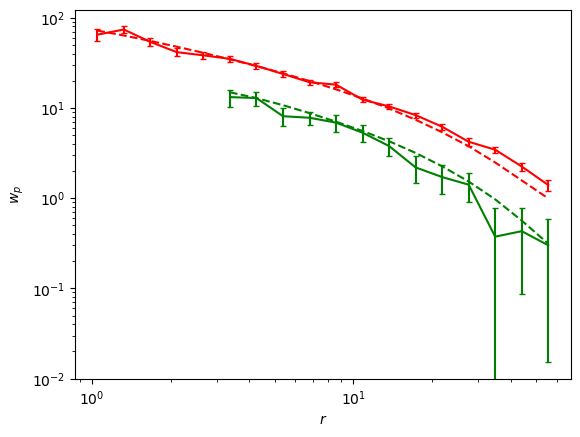

In [45]:
plt.errorbar(rp_auto, signal_auto, err_auto, fmt='r', capsize=2)
plt.errorbar(rp_cross, signal_cross, err_cross, fmt='g', capsize=2)
plt.plot(rp_auto, pre_auto, 'r--')
plt.plot(rp_cross, pre_cross, 'g--')
plt.xlabel('$r$')
plt.ylabel('$w_p$')
plt.loglog()